In [1]:
# connect to google drive. (google it how to use it if you don't know already)
# this code cell will ask for permission of your google account. 
# give access and refresh folder icon under files to see the change.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# use this cell if you are uploading data directory (dir) instead of zip file
# NOTE: uploading unzipped file could be fatal in google colab because of random i/o latency.
# uploading zip file is the safest option.
# try to put the dataset in top file directory i.e. under gdrive/drive to reduce i/o errors.
# e.g. putting data.zip under gdrive/project/thesis/lip_reading/data.zip will take more time for i/o operation than just gdrive/data.zip.
# you can create a secondary new google account just for your thesis to avoid these type of problems. 

# !rmdir -rf data # remove dir named data
# !mkdir data # create dir named data
# !rm -rf /content/data # delete a non empty directory.

In [4]:
!unzip /content/drive/MyDrive/lip_reading/data.zip # unzipping dataset

Archive:  /content/drive/MyDrive/lip_reading/data.zip
   creating: content/data/
 extracting: content/data/test.zip   
 extracting: content/data/train.zip  
  inflating: content/data/sample_submission.csv  
  inflating: content/data/val.csv    
 extracting: content/data/val.zip    
  inflating: content/data/train.csv  
  inflating: content/data/vocabulary.txt  


In [5]:
# unzipping internal zips
!unzip /content/content/data/train.zip -d /content/content/data/train > /dev/null
!unzip /content/content/data/val.zip -d /content/content/data/val > /dev/null
!unzip /content/content/data/test.zip -d /content/content/data/test > /dev/null

In [6]:
# as the zips cost small amount of storage so we are not deleting it.
# but keep your eyes on the top right corner whether the disk and ram are filling up or not.

# to delete zips use !rm commands as above after completing unzipping to save storage for later operations (ops)
# !rm /content/content/data/test.zip
# !rm /content/content/data/train.zip
# !rm /content/content/data/val.zip

In [7]:
# we will use some external libraries to handle our special category (catg) of data.
# (1) MediaPipe, (2) protobuf3-to-dict 

# MediaPipe, ref - https://google.github.io/mediapipe/getting_started/python.html
# open source library (lib) by google, it got some useful features for tasks like:
# - face detetecion, https://en.wikipedia.org/wiki/Face_detection
# - keypoints detection, https://paperswithcode.com/task/keypoint-detection
# - pose estimation, https://paperswithcode.com/task/pose-estimation

# NOTE: paperswithcode is an important search space for researchers, try to roam this site.

# protobuf3-to-dict, ref - https://pypi.org/project/protobuf3-to-dict/
# it will be useful for us as it will help MediaPipe output to convert into a dictionary format.
# we will learn about its' usefulness in upcoming cells 

In [8]:
!pip install mediapipe # version installed -0.8.10.1
!pip install protobuf3-to-dict # version installed 0.1.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for protobuf3-to-dict: filename=protobuf3_to_dict-0.1.5-py3-none-any.whl size=4030 sha256=8f9506c7e07d5e41a892f9233920a300153df21f9983a439e365fa7bb012dad4
  Stored in directory: /root/.cache/pip/wheels/ce/a0/8b/995ce2fbaf0e9fe7eb91da84e99e84d1b35cfaa555f2b8f1c7
Successfully built protobuf3-to-dict


In [9]:
import pandas as pd

# Reading data folders
TRAIN_DATA_PATH = '/content/content/data/train'
VAL_DATA_PATH = '/content/content/data/val/'

# Reading data files
df_train = pd.read_csv('/content/content/data/train.csv')
df_val = pd.read_csv('/content/content/data/val.csv')

# Reading vocabulary list
df_vocab = pd.read_csv('/content/content/data/vocabulary.txt', header = None)

In [10]:
import os

# Checking training and validation images count
print("Training Images    : ", len(os.listdir(TRAIN_DATA_PATH)))
print("Validation Images  : ", len(os.listdir(VAL_DATA_PATH)), "\n")

# Checking training and validation dataset dimensions
print("Training   :", df_train.shape)
print("Validation :", df_val.shape)

# Checking vocabulary
print("Vocabulary :", df_vocab.shape)

Training Images    :  3000
Validation Images  :  500 

Training   : (3000, 2)
Validation : (500, 2)
Vocabulary : (400, 1)


In [11]:
# Indexing Vocabulary
# Here we will look at all the unique words from the vocabulary and assign 
# a unique number to each word that represents it - essentially creating a 
# 'word to index or word2idx' lookup that converts a given word to a class number. 
# While decoding the predictions during model inference, the 'index to word or idx2word' 
# lookup could be used to get the relevant words from their class number.

# creating sorted list of all words in vocabulary; before that putting it in a set
# to remove duplicates.
vocab_lst = sorted(list(set(list(df_vocab.iloc[:, 0]))))

# creating word -> idx dictionary
word2idx = {}
for idx,word in enumerate(vocab_lst):
    word2idx[word] = idx

# displaying few indexes
print("Word Indexing")
for word in list(word2idx)[:10]:
    print('{0: <12}'.format(word), ":", word2idx[word])


NUM_CLASSES = len(word2idx)
print(f"\nVocabulary count : {NUM_CLASSES}")

Word Indexing
accelerate   : 0
accept       : 1
achieve      : 2
activate     : 3
address      : 4
administer   : 5
agree        : 6
alight       : 7
allow        : 8
altered      : 9

Vocabulary count : 400


In [12]:
# DATA CLEANING


# Now we will look at the data. 
# It is a good practice to check if all the images are readable. 
# In case any images in the data are corrupted, this will create an issue 
# in upcoming steps. Here, we will go through the data and fix any discrepancies.

# Checking files and dropping rows from df if any data is not readable


# training files check
train_files = os.listdir(TRAIN_DATA_PATH)
df = df_train
for file_name in df_train['file_name']:
    if file_name not in train_files:
        df=df.drop(df[df['file_name']==file_name].index)
        
df_train = df
print(f"Cleaned Training   :{df_train.shape}")



# validation files check
val_files = os.listdir(VAL_DATA_PATH)
df = df_val
for file_name in df_val['file_name']:
    if file_name not in val_files:
        df=df.drop(df[df['file_name']==file_name].index)

df_val = df
print(f"Cleaned Validation :{df_val.shape}")

# after the run it seems like there are no unreadable or missing data. 

Cleaned Training   :(3000, 2)
Cleaned Validation :(500, 2)


In [13]:
from base64 import b64encode
from IPython.display import HTML

# lets see a sample data
# ref - https://stackoverflow.com/a/61569761

def show_video(video_path):
  """Function (func) to show video by path"""

  mp4 = open(video_path,'rb').read()
  decoded_vid = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f'<video width=400 controls><source src={decoded_vid} type="video/mp4"></video>')

In [14]:
print(df_train['word'][0])
print(df_train['file_name'][0])
show_video("/content/content/data/train/0.mp4")

hypothesize
0.mp4


Random Sample from dataset

PATH:  /content/content/data/train/1686.mp4
WORD:  present


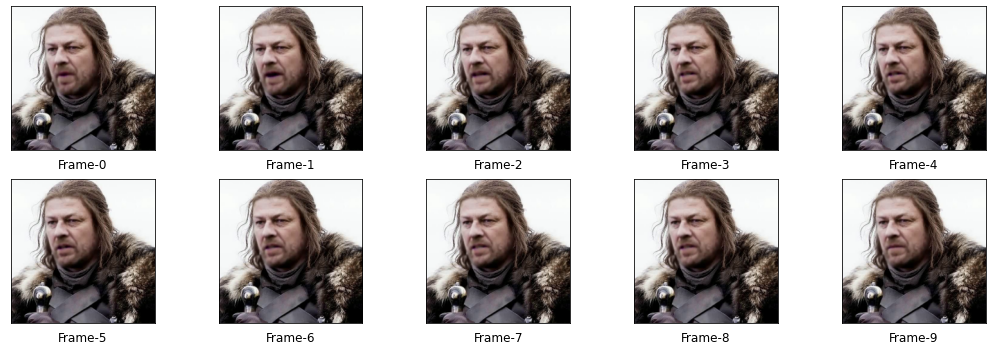

In [15]:
# viewing 10 frames from a sample video data.

# (IMPORTANT NOTE)
# we can not use a video directly to train our model. 
# We need to load all the frames from each video 
# and process them to create a 3-dimensional batch consisting of 
# N two-dimensional frames. 
# Let's have a look at N frames from a sample video.


import cv2 
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# understanding the functions below is not that much neccessary.
def read_video_frames(video_file_path):
    # reading the first frame
    frames = []
    try:
        cap = cv2.VideoCapture(video_file_path)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224))
        frames.append(frame)
    except:
        pass
    # while a next frame exists, we accumulate frames
    while ret:
        try:
            ret, frame = cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
        except:
            continue
    
    return frames[:10]


# Function to plot frames of a video
def plot_video(video_file_path, cols = 5, ht = 18):
    video_frames = read_video_frames(video_file_path)
    FRAMES = 10
    COLS = 5
    ROWS = (FRAMES//COLS)+1
    fig = plt.figure(figsize = (ht, 3*ROWS))
    for idx in range(FRAMES):
        ax = fig.add_subplot(ROWS, COLS, idx+1)
        ax.set_xticks([])
        ax.set_yticks([])
        # print("idx ", idx)
        ax.imshow(video_frames[idx])
        ax.text(0.5, 
                -0.1, 
                f'Frame-{str(idx):s}',
                size = 12, 
                horizontalalignment = 'center', 
                verticalalignment = 'center', 
                transform = ax.transAxes)



print("Random Sample from dataset\n")
random_row = df_train.iloc[random.choice(range(len(df_train)))]
print("PATH: ", TRAIN_DATA_PATH + '/' + random_row[0])
print("WORD: ", random_row[1])
plot_video(TRAIN_DATA_PATH + '/' + random_row[0])
plt.show()

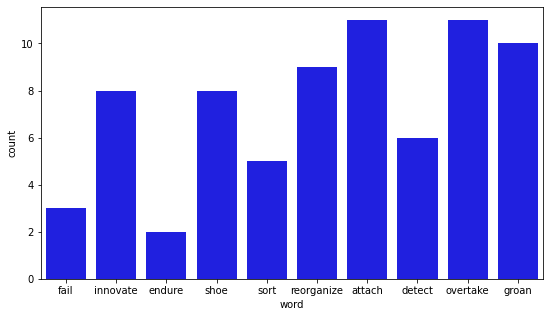

In [16]:
# Let's do the EDA now.

# In this, we plot the count of #training_samples available for a set 
# of random words from the training vocabulary, where the 
# ('frequency count' is plotted on the 'y-axis') against the ('word' on the 'x-axis'). 
# This is done to explore the dataset and get an idea about the number of samples per word.

import seaborn as sns

# Plotting count of samples of random words in dataset
plt.figure(figsize = (9,5))
sns.countplot(x = df_train['word'],
              order = df_train['word'].value_counts().sample(10).index, 
              orient = "h",
              color = "blue")
plt.show()


  0%|          | 0/3000 [00:00<?, ?it/s]

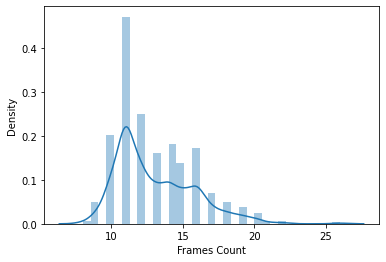

In [17]:
# FRAMES DISTRIBUTION


from tqdm.notebook import tqdm


# As the duration of each video varies, the number of frames in each video also varies. 
# But, to train our model we require fixed input dimensions. 
# So, here we plot the number of frames in a video on the x-axis against the count 
# of how many such videos exist on the y-axis. This allows us to set the 
# 'MAX_FRAMES' and fix the dimensions of input to the model.

def get_frames_count(video_file_path):
    cap = cv2.VideoCapture(video_file_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # watch from doc how cv2.CAP_PROP_FRAME_COUNT works. 
    return length


frames_dist = []
for file in tqdm(os.listdir(TRAIN_DATA_PATH)):
    frames_dist.append(get_frames_count(TRAIN_DATA_PATH + '/' + file))

sns.distplot(frames_dist, kde=True)
plt.xlabel("Frames Count")
plt.show()

In [18]:
# Current state of dataset is not much useful to proceed further, 
# so we will apply some processing functions on the dfs to proceed further 
# for train-val data generation.
# We will do: 
#  - Reading frames from the videos
#  - Extracting face region from the frames
#  - Grayscaling the images to reduce the number of channels, refs - https://en.wikipedia.org/wiki/Grayscale
#  - Writing processed frames to disk accordingly


# What effect would tweaking the Max number of frames have? 
# - Increasing 'MAX_FRAMES' will make room for more input for each video and will improve the model's performance
# - Decreasing 'MAX_FRAMES' will reduce the dataset size and make training faster.

In [19]:
# Setting max number of frames to be extracted from each video

# WORK ON THIS HYPERPARAMETER WHILE EXPERIMENTING

MAX_FRAMES = 20

In [43]:
# Extracting faces using Mediapipe face detection model

# Identifying the region of interest (ROI) in the video is key to predicting 
# the word spoken. Here it is the mouth movement on the face. 
# The rest of the information in the frames doesn't contribute much to the 
# prediction rather might add unnecessary noise affecting the performance 
# of the model. To extract this ROI we are using 
# the Mediapipe library that provides face detection out of the box directly.
# ref - https://google.github.io/mediapipe/solutions/face_detection


import mediapipe as mp


# Function to extract face region from first frame to
# pass to video_to_frames to extract face from all frames

def extract_face_roi(video_file_path):
    # capturing first frame of video
    cap = cv2.VideoCapture(video_file_path)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = frame
    image_size = (image.shape[0], image.shape[1])
    
    # initializing face detection model and detecting face
    mp_face_detection = mp.solutions.face_detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        results = face_detection.process(image.astype(np.uint8))
        if not results.detections:
            raise Exception("No Face Error")
    
        for detection in results.detections:            
            bbox = detection.location_data.relative_bounding_box   
            xmin = int(bbox.xmin*image_size[1])
            ymin = int(bbox.ymin*image_size[0])
            width = int(bbox.width*image_size[1])
            height = int(bbox.height*image_size[0])
            roi_face = [xmin, ymin, width, height]
    return roi_face

In [44]:
# Function to read all the MAX_FRAMES number of frames from the video
# Using the ROI co-ordinated from face extraction model
# Finally grayscaling the frames

def video_to_frames(video_file_path, max_frames=30, IMAGE_SIZE = (224, 224), roi_face=None):
    frames = []
    try:
        cap = cv2.VideoCapture(video_file_path)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if roi_face is not None:
            xmin, ymin, width, height = roi_face
            frame = frame[ymin:ymin + height, xmin:xmin + width]
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, IMAGE_SIZE)
        frames.append(frame)
    except:
        pass
    while ret:
        ret, frame = cap.read()
        try:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if roi_face is not None:
                xmin, ymin, width, height = roi_face
                frame = frame[ymin:ymin + height, xmin:xmin + width]
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, IMAGE_SIZE)
            frames.append(frame)
        except:
            continue
    
    frames = frames[:max_frames]
    frames = np.array(frames)
    
    # adding padding to videos having less frames than MAX_FRAMES
    frames_count = frames.shape[0]
    if frames_count < max_frames:
        diff_frames = abs(max_frames-frames_count)
        zeroes_frame = np.zeros((1,)+IMAGE_SIZE)
        for _ in range(diff_frames):
            frames = np.append(frames, zeroes_frame, axis=0)
    
    assert frames.shape[0]==max_frames, "Fames Count != MAX_FRAMES"
    return frames

Random Sample from Processed dataset - Face Extracted

Word  :   concern


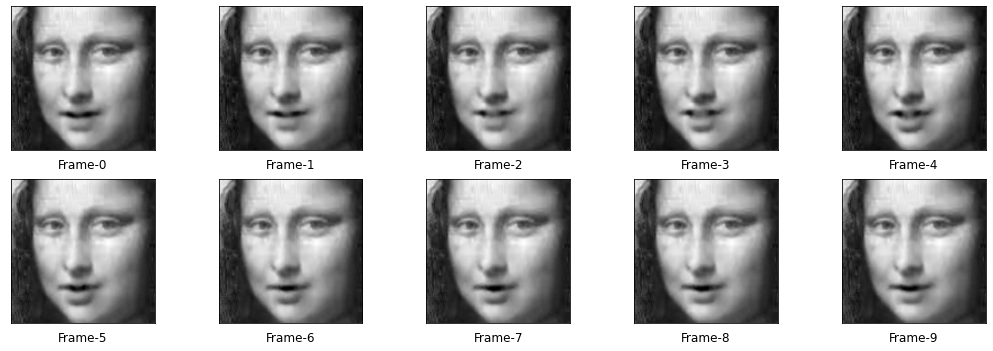

In [45]:
import numpy as np

# Function to plot frames of a video
def plot_video(video_file_path, cols = 5, ht = 18):
    roi_face = extract_face_roi(video_file_path)
    video_frames = video_to_frames(video_file_path, max_frames = MAX_FRAMES, roi_face = roi_face)
    FRAMES = 10
    COLS = 5
    ROWS = (FRAMES // COLS) + 1
    fig = plt.figure(figsize = (ht, 3*ROWS))
    for idx in range(FRAMES):
        ax = fig.add_subplot(ROWS, COLS, idx+1)
        ax.set_xticks([])
        ax.set_yticks([])

        ax.imshow(video_frames[idx], cmap = "gray")
        ax.text(0.5, 
                -0.1, 
                f'Frame-{str(idx):s}',
                size = 12, 
                horizontalalignment = 'center', 
                verticalalignment = 'center', 
                transform = ax.transAxes)



print("Random Sample from Processed dataset - Face Extracted\n")
random_row = df_train.iloc[random.choice(range(len(df_train)))]
print("Word  :  ", random_row[1])
plot_video(TRAIN_DATA_PATH + '/' + random_row[0])
plt.show()

In [46]:
# Processing training data and writing to disk

from PIL import Image

TRAINVIDEOS_BASE_DIR = "/content/content/data/train_videos/" # you can save this files in google drive, just run it once, after saving, comment out the whole cell unless you make any changes in dataset.
try:
    os.mkdir(TRAINVIDEOS_BASE_DIR)
    print("BASE_DIR Created")
except:
    pass

for video in tqdm(df_train['file_name']):
    file_name = TRAIN_DATA_PATH + '/' + video
    roi_face = extract_face_roi(file_name)
    video_frames = video_to_frames(file_name, max_frames=MAX_FRAMES, roi_face=roi_face)

    try:
        video_dir = TRAINVIDEOS_BASE_DIR + str(video)
        os.mkdir(video_dir)
    except:
        continue

    for idx,frame in enumerate(video_frames):
        PIL_image = Image.fromarray(frame.astype('uint8'))
        PIL_image.save(video_dir + "/" + f'{idx:02d}' +".png")

  0%|          | 0/3000 [00:00<?, ?it/s]

In [48]:
from PIL import Image 

# Processing validation data and writing to disk

VALVIDEOS_BASE_DIR = "/content/content/data/val_videos/" # you can save this files in google drive, just do it once, after saving comment out the whole cell unless you make any changes in dataset.
try:
    os.mkdir(VALVIDEOS_BASE_DIR)
    print("BASE_DIR Created")
except:
    pass

for video in tqdm(df_val['file_name']):
    file_name = VAL_DATA_PATH + '/' + video
    roi_face = extract_face_roi(file_name)
    video_frames = video_to_frames(file_name, max_frames=MAX_FRAMES, roi_face=roi_face)

    try:
        video_dir = VALVIDEOS_BASE_DIR + str(video)
        os.mkdir(video_dir)
    except:
        continue

    for idx,frame in enumerate(video_frames):
        PIL_image = Image.fromarray(frame.astype('uint8'))
        PIL_image.save(video_dir + "/" + f'{idx:02d}' +".png")

  0%|          | 0/500 [00:00<?, ?it/s]

In [54]:
# if you haven't run last 2 cells.
TRAINVIDEOS_BASE_DIR = "/content/content/data/train_videos/"
VALVIDEOS_BASE_DIR = "/content/content/data/val_videos/"

In [ ]:
# changing video name to filename including full path to feed into image generator
df_train['file_name'] = TRAINVIDEOS_BASE_DIR + df_train['file_name']
df_train.word = df_train.word.apply(lambda x:word2idx[x])
df_train.head(5)

In [ ]:
# changing video name to filename including full path to feed into image generator
df_val['file_name'] = VALVIDEOS_BASE_DIR + df_val['file_name']
df_val.word = df_val.word.apply(lambda x:word2idx[x])
df_val.head(5)